## San Diego Street Conditions Classification

A Cloud Computing Project by Leonid Shpaner, Jose Luis Estrada, and Kiran Singh

In [1]:
import boto3
import sagemaker
from pyathena import connect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable 
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Data Wrangling

In [2]:
# create athena database
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
# s3 = boto3.Session().client(service_name="s3", region_name=region)

# ec2 = boto3.Session().client(service_name="ec2", region_name=region)
# sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [3]:
ingest_create_athena_db_passed = False

In [4]:
# set a database name
database_name = "watersd"

In [5]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [6]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [7]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS watersd


""


In [8]:
water_dir = 's3://waterteam1/raw_files'

In [9]:
# SQL statement to execute the analyte tests drinking water table

table_name ='oci_2015_datasd'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name}(
                seg_id string,
                oci float,
                street string,
                street_from string,
                street_to string,
                seg_length_ft float,
                seg_width_ft float,
                func_class string,
                pvm_class string,
                area_sq_ft float,
                oci_desc string,
                oci_wt float
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{water_dir}/{table_name}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name} LIMIT 5', conn)

,seg_id,oci,street,street_from,street_to,seg_length_ft,seg_width_ft,func_class,pvm_class,area_sq_ft,oci_desc,oci_wt
0,SA-000003,65.14,ALLEY,,,772.7258,30.0,Alley,PCC Jointed Concrete,23181.773,Fair,1510060.80
1,SA-000004,67.45,ALLEY,,,196.0025,30.0,Alley,PCC Jointed Concrete,5880.075,Fair,396611.06
2,SA-000005,70.88,ALLEY,,,395.0049,30.0,Alley,PCC Jointed Concrete,11850.147,Good,839938.44
3,SA-000006,84.00,ALLEY,,,192.0025,30.0,Alley,PCC Jointed Concrete,5760.075,Good,483846.30
4,SA-000008,79.24,ALLEY,,,251.7540,30.0,Alley,PCC Jointed Concrete,7552.620,Good,598469.60


In [10]:
# SQL statement to execute the analyte tests drinking water table

table_name2 ='sd_paving_datasd'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name2}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name2}(
                pve_id int,
                seg_id string,
                project_id string,
                title string,
                project_manager string,
                project_manager_phone string,
                status string,
                type string,
                resident_engineer string,
                address_street string,
                street_from string,
                street_to string,
                seg_cd int,
                length int,
                width int,
                date_moratorium date,
                date_start date,
                date_end date,
                paving_miles float
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{water_dir}/{table_name2}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name2} LIMIT 5', conn)

,pve_id,seg_id,project_id,title,project_manager,project_manager_phone,status,type,resident_engineer,address_street,street_from,street_to,seg_cd,length,width,date_moratorium,date_start,date_end,paving_miles
0,1073577074,SA-000319,UTLY,Public Works CIP,Engineering@sandiego.gov,858-627-3200,post construction,Overlay,ECP,ALLEY,,,2,0,NaN,2019-02-02,2019-02-02,2019-02-02,0.000000
1,1792486183,SA-000345,UTLY,Public Works CIP,Engineering@sandiego.gov,858-627-3200,post construction,Slurry,ECP,ALLEY,,,2,938,30.0,2019-01-30,2019-01-30,2019-01-30,0.177652
2,1173780646,SA-000375,UTLY,Public Works CIP,Engineering@sandiego.gov,858-627-3200,post construction,Slurry,ECP,ALLEY,,,2,674,30.0,2018-08-01,2018-08-01,2018-08-01,0.127652
3,1276790298,SA-000378,UTLY,Public Works CIP,Engineering@sandiego.gov,858-627-3200,post construction,Slurry,ECP,ALLEY,,,2,658,30.0,2018-08-01,2018-08-01,2018-08-01,0.124621
4,27170959,SA-001081,UTLY,Public Works CIP,Engineering@sandiego.gov,858-627-3200,post construction,Concrete,ECP,ALLEY,,,9,680,30.0,None,2020-08-13,2020-08-13,0.128788


In [11]:
# SQL statement to execute the analyte tests drinking water table

table_name3 ='traffic_counts_datasd'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name3}', conn)


create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name3}(
                id string,
                street_name string,
                limits string,
                northbound_count int,
                southbound_count int,
                eastbound_count int,
                westbound_count int,
                total_count int,
                file_no string,
                date_count date
                )
                
                ROW FORMAT DELIMITED
                FIELDS TERMINATED BY ','
                LOCATION '{water_dir}/{table_name3}'
                TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name3} LIMIT 5', conn)

,id,street_name,limits,northbound_count,southbound_count,eastbound_count,westbound_count,total_count,file_no,date_count
0,01AV018207,01 AV,A ST - ASH ST,18010,None,None,None,18010,0182-07,2007-03-13
1,01AV015210,01 AV,A ST - ASH ST,20060,None,None,None,20060,0152-10,2010-03-18
2,01AV018213,01 AV,A ST - ASH ST,19597,None,None,None,19597,0182-13,2013-03-12
3,01AV007721,01 AV,A ST - ASH ST,10640,None,None,None,10640,0077-21,2021-03-10
4,01AV088812,01 AV,ASH ST - BEECH ST,2298,None,None,None,2298,0888-12,2012-12-11


In [12]:
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,watersd


In [13]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [14]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


In [15]:
pd.read_sql(f'SELECT * FROM {database_name}.{table_name} t1 INNER JOIN \
                            {database_name}.{table_name2} t2 ON t1.seg_id \
                            = t2.seg_id LIMIT 5', conn)

,seg_id,oci,street,street_from,street_to,seg_length_ft,seg_width_ft,func_class,pvm_class,area_sq_ft,...,address_street,street_from,street_to,seg_cd,length,width,date_moratorium,date_start,date_end,paving_miles
0,SA-000345,34.14,ALLEY,,,937.9261,30.0,Alley,AC Improved,28137.783,...,ALLEY,,,2,938,30,2019-01-30,2019-01-30,2019-01-30,0.177652
1,SA-000375,97.25,ALLEY,,,673.3209,30.0,Alley,PCC Jointed Concrete,20199.627,...,ALLEY,,,2,674,30,2018-08-01,2018-08-01,2018-08-01,0.127652
2,SA-000378,62.67,ALLEY,,,657.2000,30.0,Alley,PCC Jointed Concrete,19716.000,...,ALLEY,,,2,658,30,2018-08-01,2018-08-01,2018-08-01,0.124621
3,SA-001081,68.86,ALLEY,,,679.1060,30.0,Alley,PCC Jointed Concrete,20373.180,...,ALLEY,,,9,680,30,None,2020-08-13,2020-08-13,0.128788
4,SA-001083,28.67,ALLEY,,,660.0917,30.0,Alley,PCC Jointed Concrete,19802.752,...,ALLEY,,,9,661,30,None,2020-07-31,2020-07-31,0.125189


In [16]:
df = pd.read_sql(f'SELECT * FROM (SELECT * FROM {database_name}.{table_name} \
                           t1 INNER JOIN {database_name}.{table_name2} t2 \
                           ON t1.seg_id = t2.seg_id) m1 LEFT JOIN (SELECT street_name, \
                                                                   SUM(total_count) total_count \
                                                                   FROM {database_name}.{table_name3} \
                                                                   GROUP BY street_name) t3 \
                           ON m1.address_street = t3.street_name', conn)

In [17]:
df.head(5)

,seg_id,oci,street,street_from,street_to,seg_length_ft,seg_width_ft,func_class,pvm_class,area_sq_ft,...,street_to,seg_cd,length,width,date_moratorium,date_start,date_end,paving_miles,street_name,total_count
0,SA-000345,34.14,ALLEY,,,937.9261,30.0,Alley,AC Improved,28137.783,...,,2,938,30,2019-01-30,2019-01-30,2019-01-30,0.177652,None,NaN
1,SA-000375,97.25,ALLEY,,,673.3209,30.0,Alley,PCC Jointed Concrete,20199.627,...,,2,674,30,2018-08-01,2018-08-01,2018-08-01,0.127652,None,NaN
2,SA-000378,62.67,ALLEY,,,657.2000,30.0,Alley,PCC Jointed Concrete,19716.000,...,,2,658,30,2018-08-01,2018-08-01,2018-08-01,0.124621,None,NaN
3,SA-001081,68.86,ALLEY,,,679.1060,30.0,Alley,PCC Jointed Concrete,20373.180,...,,9,680,30,None,2020-08-13,2020-08-13,0.128788,None,NaN
4,SA-001083,28.67,ALLEY,,,660.0917,30.0,Alley,PCC Jointed Concrete,19802.752,...,,9,661,30,None,2020-07-31,2020-07-31,0.125189,None,NaN


In [18]:
# remove duplicated columns
df = df.loc[:,~df.columns.duplicated()]

## Exploratory Data Analysis (EDA)

In [19]:
# get number of rows and columns
print('Number of Rows:', df.shape[0])
print('Number of Columns:', df.shape[1], '\n')

# inspect datatypes and nulls
data_types = df.dtypes
data_types = pd.DataFrame(data_types)
data_types = data_types.assign(Null_Values = 
                               df.isnull().sum())
data_types.reset_index(inplace = True)
data_types.rename(columns={0:'Data Type',
                          'index': 'Column/Variable',
                          'Null_Values': "# of Nulls"})

Number of Rows: 23005
Number of Columns: 30 



,Column/Variable,Data Type,# of Nulls
0,seg_id,object,0
1,oci,float64,0
2,street,object,0
3,street_from,object,0
4,street_to,object,0
5,seg_length_ft,float64,0
6,seg_width_ft,float64,0
7,func_class,object,0
8,pvm_class,object,0
9,area_sq_ft,float64,0


### Bias Exploration
To explore potential areas of bias, we will endeavor to trace class imbalance on the target feature of "oci_desc."

In [20]:
oci_desc_fair = df['oci_desc'].value_counts()['Fair']
oci_desc_good = df['oci_desc'].value_counts()['Good']
oci_desc_poor = df['oci_desc'].value_counts()['Poor']
oci_desc_total = oci_desc_fair  + oci_desc_good + oci_desc_poor

table1 = PrettyTable() # build a table
table1.field_names = ['Fair Condition', 'Good Condition', 
                      'Poor Condition', 'Total']
table1.add_row([oci_desc_fair, oci_desc_good, oci_desc_poor, 
                oci_desc_total])
table1

Fair Condition,Good Condition,Poor Condition,Total
6105,15758,1142,23005


In [21]:
perc_good = oci_desc_good /(oci_desc_total) 
perc_fair = oci_desc_fair /(oci_desc_total)
perc_poor = oci_desc_poor /(oci_desc_total)
print(round(perc_good, 2)*100, '% of streets '
                       'are in good condition ')
print(round(perc_fair, 2)*100, '% of streets '
                       'are in fair condition ')
print(round(perc_poor, 2)*100, '% of streets '
                       'are in poor condition ')

68.0 % of streets are in good condition 
27.0 % of streets are in fair condition 
5.0 % of streets are in poor condition 


Considerably more than half of the streets are in good condition. A little less than a third are in fair condition. Only 5% are in poor condition.

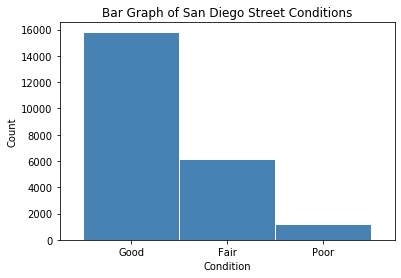

Good    15758
Fair     6105
Poor     1142
Name: oci_desc, dtype: int64

In [22]:
# accidents injury bar graph
conditions = df['oci_desc'].value_counts()
fig = plt.figure()
conditions.plot.bar(x ='lab', y='val', rot=0, width=0.99, 
                         color="steelblue")
plt.title ('Bar Graph of San Diego Street Conditions')
plt.xlabel('Condition') 
plt.ylabel('Count')
plt.show()

conditions

Whereas a method can be used to classify street conditions into multiple classes, it is easier to re-classify streets in “fair” and “good” condition into one category in comparison with the poor class. This, in turn, becomes a binary classification problem. Thus, there are now 21,863 streets in good condition and 1,142 in poor condition (only 5% of all streets). This presents a definitive example of class imbalance.

In [23]:
df['oci_cat'] = df['oci_desc'].map({'Good':1, 'Fair':1,
                                    'Poor':0})
cond = df['oci_cat'].value_counts()
cond

1    21863
0     1142
Name: oci_cat, dtype: int64

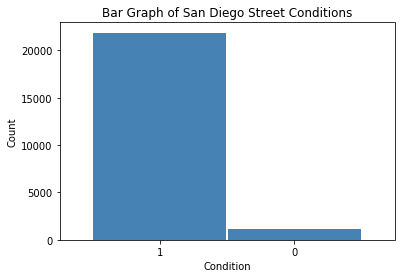

1    21863
0     1142
Name: oci_cat, dtype: int64

In [24]:
# oci ratings bar graph
fig = plt.figure()
cond.plot.bar(x ='lab', y='val', rot=0, width=0.99, 
                         color="steelblue")
plt.title ('Bar Graph of San Diego Street Conditions')
plt.xlabel('Condition') 
plt.ylabel('Count')
plt.show()

cond

In [25]:
# cast oci info into range of values
labels = [ "{0} - {1}".format(i, i + 5) for i in range(0, 100, 10) ]
df['OCI Range'] = pd.cut(df.oci, range(0, 105, 10), 
                                right=False, 
                                labels=labels).astype(object)
# inspect the new dataframe with this info
df[['oci', 'OCI Range']]

,oci,OCI Range
0,34.14,30 - 35
1,97.25,90 - 95
2,62.67,60 - 65
3,68.86,60 - 65
4,28.67,20 - 25
...,...,...
23000,93.40,90 - 95
23001,91.01,90 - 95
23002,97.26,90 - 95
23003,95.00,90 - 95


In [26]:
print("\033[1m"+'Street Conditions by Condition Index Range'+"\033[1m")
def oci_cond():
    oci_desc_good = df.loc[df.oci_desc == 'Good'].groupby(
                               ['OCI Range'])[['oci_desc']].count()
    oci_desc_good.rename(columns = {'oci_desc':'Good'}, inplace=True)

    oci_desc_fair = df.loc[df.oci_desc == 'Fair'].groupby(
                               ['OCI Range'])[['oci_desc']].count()
    oci_desc_fair.rename(columns = {'oci_desc':'Fair'}, inplace=True)

    oci_desc_poor = df.loc[df.oci_desc == 'Poor'].groupby(
                               ['OCI Range'])[['oci_desc']].count()
    oci_desc_poor.rename(columns = {'oci_desc':'Poor'}, inplace=True)

    oci_desc_comb = pd.concat([oci_desc_good, oci_desc_fair, oci_desc_poor], 
    axis = 1)
    # sum row totals
    oci_desc_comb.loc['Total']= oci_desc_comb.sum(numeric_only=True, axis=0)
    # sum column totals
    oci_desc_comb.loc[:,'Total'] = oci_desc_comb.sum(numeric_only=True, axis=1)

    oci_desc_comb.fillna(0, inplace = True)
    return oci_desc_comb.style.format("{:,.0f}")

oci_cond = oci_cond().data # retrieve dataframe
oci_cond

Street Conditions by Condition Index Range


,Good,Fair,Poor,Total
70 - 75,4766.0,3.0,0.0,4769.0
80 - 85,7341.0,0.0,0.0,7341.0
90 - 95,3541.0,0.0,0.0,3541.0
40 - 45,0.0,1095.0,0.0,1095.0
50 - 55,0.0,1685.0,0.0,1685.0
60 - 65,0.0,3322.0,0.0,3322.0
0 - 5,0.0,0.0,37.0,37.0
10 - 15,0.0,0.0,135.0,135.0
20 - 25,0.0,0.0,259.0,259.0
30 - 35,0.0,0.0,711.0,711.0


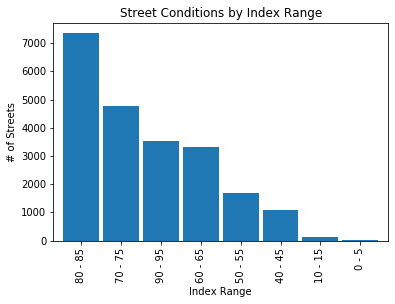

In [27]:
oci_plt = oci_cond['Total'][0:8].sort_values(ascending=False)
oci_plt.plot(kind='bar', width=0.90)
plt.title('Street Conditions by Index Range')
plt.xlabel('Index Range')
plt.ylabel('# of Streets')
plt.show()

### Summary Statistics

In [28]:
# summary statistics
summ_stats = pd.DataFrame(df['oci'].describe()).T
summ_stats

,count,mean,std,min,25%,50%,75%,max
oci,23005.0,74.791413,16.784048,0.0,66.3,79.06,87.3,100.0


In [29]:
IQR = summ_stats['75%'][0] - summ_stats['25%'][0]
low_outlier = summ_stats['25%'][0] - 1.5*(IQR)
high_outlier = summ_stats['75%'][0] + 1.5*(IQR)
print('Low Outlier:', low_outlier)
print('High Outlier:', high_outlier)

Low Outlier: 34.8
High Outlier: 118.8


In [30]:
print("\033[1m"+'Overall Condition Index (OCI) Summary'+"\033[1m")
def oci_by_range():
    pd.options.display.float_format = '{:,.2f}'.format
    new = df.groupby('OCI Range')['oci']\
    .agg(["mean", "median", "std", "min", "max"])
    new.loc['Total'] = new.sum(numeric_only=True, axis=0)
    column_rename = {'mean': 'Mean', 'median': 'Median',
                     'std': 'Standard Deviation',\
                     'min':'Minimum','max': 'Maximum'}
    dfsummary = new.rename(columns = column_rename)
    return dfsummary
oci_by_range = oci_by_range()
oci_by_range

Overall Condition Index (OCI) Summary


,Mean,Median,Standard Deviation,Minimum,Maximum
OCI Range,,,,,
0 - 5,6.13,8.00,3.70,0.00,9.69
10 - 15,15.66,16.40,2.82,10.11,19.84
20 - 25,25.77,26.17,2.91,20.12,29.96
30 - 35,35.63,36.04,2.80,30.04,39.98
40 - 45,45.37,45.58,2.88,40.00,49.98
50 - 55,55.62,56.00,2.88,50.00,59.98
60 - 65,65.56,65.80,2.82,60.00,69.99
70 - 75,75.11,75.16,2.97,70.00,79.99
80 - 85,85.14,85.15,2.84,80.00,89.99


### Histogram Distributions

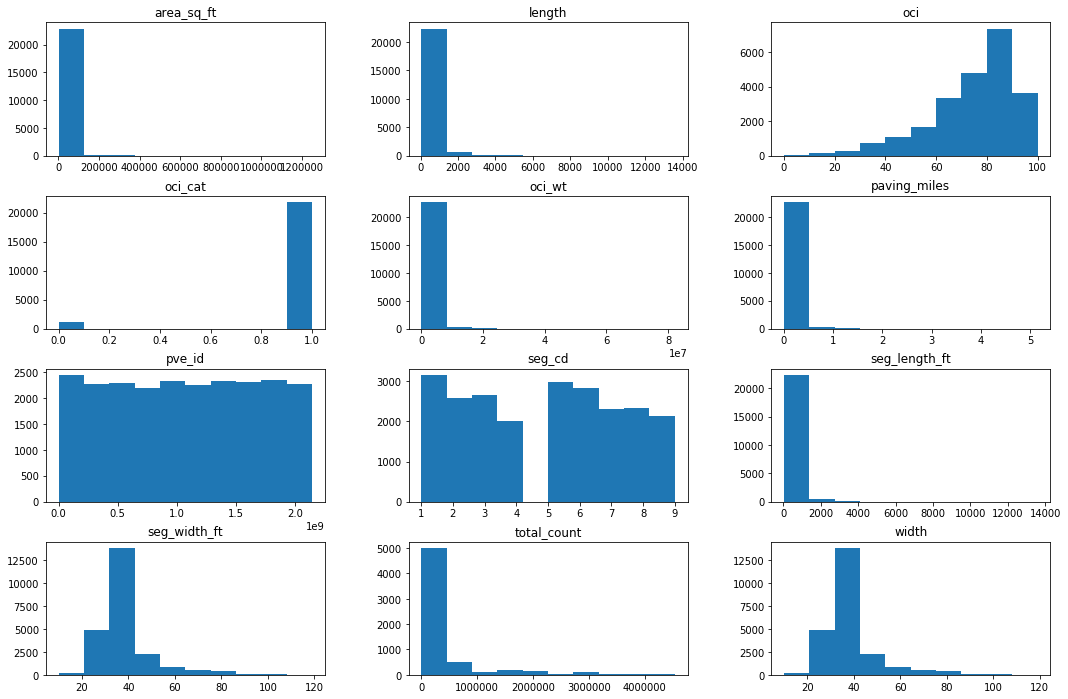

In [31]:
# histograms
df.hist(grid=False, figsize=(18,12))
plt.show()

### Boxplot Distribution (OCI)

Boxplot Distribution


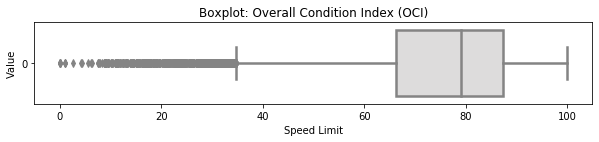

The first quartile is 66.3. 
The third quartile is 87.3. 
The IQR is 21.0.
The mean is 74.79. 
The standard deviation is 16.78. 
The median is 79.06. 


In [32]:
# selected boxplot distribution for oci values
print("\033[1m"+'Boxplot Distribution'+"\033[1m")

# Boxplot of age as one way of showing distribution
fig = plt.figure(figsize = (10,1.5))
plt.title ('Boxplot: Overall Condition Index (OCI)')
plt.xlabel('Speed Limit')
plt.ylabel('Value')
sns.boxplot(data=df['oci'], 
            palette="coolwarm", orient='h', 
            linewidth=2.5)
plt.show()

IQR = summ_stats['75%'][0] - summ_stats['25%'][0]

print('The first quartile is %s. '%summ_stats['25%'][0])
print('The third quartile is %s. '%summ_stats['75%'][0])
print('The IQR is %s.'%round(IQR,2))
print('The mean is %s. '%round(summ_stats['mean'][0],2))
print('The standard deviation is %s. '%round(summ_stats['std'][0],2))
print('The median is %s. '%round(summ_stats['50%'][0],2))

### Correlation Matrix

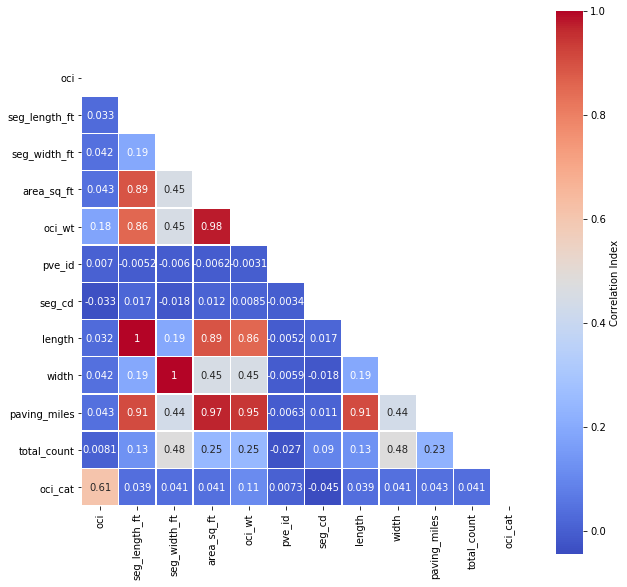

In [33]:
# assign correlation function to new variable
corr = df.corr()
matrix = np.triu(corr) # for triangular matrix
plt.figure(figsize=(10,10))
# parse corr variable intro triangular matrix
sns.heatmap(df.corr(method='pearson'), 
            annot=True, linewidths=.5, 
            cmap="coolwarm", mask=matrix,
            square = True, 
            cbar_kws={'label': 'Correlation Index'})
plt.show()

### Multicollinearity

Let us narrow our focus by removing highly correlated predictors and passing the rest into a new dataframe.

In [34]:
cor_matrix = df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),
                                     k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if 
           any(upper_tri[column] > 0.75)]
print('These are the columns prescribed to be dropped: %s'%to_drop)

These are the columns prescribed to be dropped: ['area_sq_ft', 'oci_wt', 'length', 'width', 'paving_miles']


## Pre-Processing

### Feature Engineering

The residential, collector, major, prime, local, and alley functional classes are converted to dummy variables.

In [35]:
df['func_class'].value_counts()
df['func_cat'] = df['func_class'].map({'Residential': 1, 
                                       'Collector': 2,
                                       'Major': 3, 'Prime':4,
                                       'Local':5, 'Alley':6})

The AC Improved, PCC Jointed Concrete, AC Unimproved, and UnSurfaced pavement classes are converted to dummy variables.

In [36]:
df['pvm_class'].value_counts()
df['pvm_cat'] = df['pvm_class'].map({'AC Improved': 1, 
                                     'PCC Jointed Concrete': 2,
                                     'AC Unimproved': 3, 
                                     'UnSurfaced':4})

The current status of the job (i.e., post construction, design, bid/award, construction, and planning) is also converted to dummy variables.

In [37]:
df['status'].value_counts()
df['status_cat'] = df['status'].map({'post construction': 1, 
                                     'design': 2,
                                     'bid / award': 3, 
                                     'construction':4,
                                     'planning': 5})

The start date is subtracted from the end date and converted to number of days as one column.

In [38]:
df['date_end'] = pd.to_datetime(df['date_end'])
df['date_start'] = pd.to_datetime(df['date_start'])
day_diff = df.dropna(subset=['date_end', 'date_start'],
                             inplace=True) 
df['day_diff'] = (df['date_end'] - df['date_start']).dt.days.astype(int)

### Dropping Non-Useful/Re-classed Columns

Columns with explicit titles (i.e., names) and non-convertible/non-meaningful strings are dropped. Redundant columns (columns that have been cast to dummy variables) have also been dropped in conjunction with the index column which serves no purpose for this experiment.

In [39]:
# drop unnecessary columns
df = df.drop(columns=['street_from','street_to', 
                      'street_name','total_count',
                      'seg_id', 'street', 
                      'pve_id', 'title','project_manager', 
                      'project_manager_phone', 'project_id',
                      'resident_engineer', 'address_street', 
                      'date_moratorium', 'OCI Range'])
df = df.reset_index(drop=True)

# drop re-classed columns
df = df.drop(columns=['func_class', 'pvm_class', 'status', 'type',
                      'date_end', 'date_start', 'oci_desc'])

The original dataframe is copied into a new dataframe *df1* in order to continue the final steps in the pre-processing endeavor. This is to avoid any mis-steps or adverse/unintended effects on the original dataframe.

In [40]:
# create new dataframe for final pre-processing steps
df1 = df.copy()

The dataframe can now be prepared as a flat .csv file if so desired.

In [41]:
# output to csv file as backup
# df.to_csv('sd_roads_dataframe.csv')

### Handling Class Imbalance

Multiple methods for balancing a dataset exist like “undersampling the majority classes” (Fregly & Barth, 2021, p. 178). To account for the large gap (95%) of mis-classed data on the “poor” condition class, “oversampling the minority class up to the majority class” (p. 179) is commenced. However, such endeavor cannot proceed in good faith without the unsupervised dimensionality reduction technique of Principal Component Analysis (PCA), which is carried out “to compact the dataset and eliminate irrelevant Features” (Naseriparsa & Kashani, 2014, p. 33). In this case, a new dataframe is reduced down into the first two principal components since the largest percent variance explained exists therein. 

In [42]:
# the first two principal components are used
pca = PCA(n_components=2, random_state=777)
data_2d = pd.DataFrame(pca.fit_transform(df1.iloc[:,0:9]))

The dataframe is prepared for scatterplot analysis as follows.

In [43]:
data_2d= pd.concat([data_2d, df1['oci_cat']], axis=1)
data_2d.columns = ['x', 'y', 'oci_cat']; data_2d

,x,y,oci_cat
0,"-565,511.24","14,903.90",0
1,"438,106.89","-5,292.13",1
2,"-290,656.73","3,118.86",1
3,"-123,365.87","1,734.80",1
4,"-958,462.83","11,356.77",0
...,...,...,...
22993,"-1,120,094.45","-2,138.79",1
22994,"1,469,689.03","-5,161.03",1
22995,"1,321,569.31","-6,995.59",1
22996,"-846,170.55","-2,671.76",1


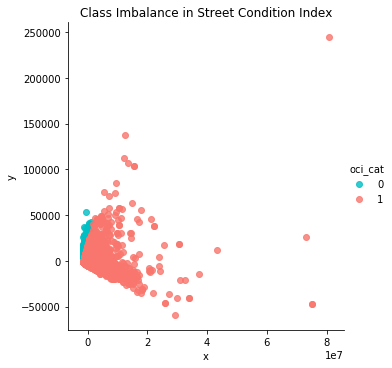

In [44]:
sns.lmplot('x','y', data_2d,fit_reg=False,hue='oci_cat',
                    palette=['#00BFC4','#F8766D'])
plt.title('Class Imbalance in Street Condition Index'); plt.show()

The dataset is oversampled into a new dataframe *df2.*

The adaptive synthetic sampling approach is leveraged in conjunction with the Synthetic Minority Over-sampling (SMOTE) technique to “balance the class distribution and increase the variety of sample domain” (p. 33). This allows for the minority class to be more closely matched (up-sampled) to the majority class for an approximately even 50/50 weight distribution.

In [45]:
ada = ADASYN(random_state=777)
X_resampled, y_resampled = ada.fit_resample(df1.iloc[:,0:13], df1['oci_cat'])

In [46]:
df2 = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
df2.columns = df1.columns

The classes are re-balanced in a new dataframe using oversampling:

In [47]:
# rebalanced classes in new df
df2['oci_cat'].value_counts()
zero_count = df2['oci_cat'].value_counts()[0]
one_count = df2['oci_cat'].value_counts()[1]
zero_plus_one = zero_count + one_count

print('Poor Condition Size:', zero_count)
print('Good Condition Size:', one_count)
print('Percent in Poor Condition:', round(zero_count/zero_plus_one,2))
print('Percent in Good Condition:', round(one_count/zero_plus_one,2))

Poor Condition Size: 21844
Good Condition Size: 21858
Percent in Poor Condition: 0.5
Percent in Good Condition: 0.5


### Train-Test-Validation Split

In [48]:
#Divide train set by .7, test set by .15, and valid set .15
size_train = 30592
size_test = 6555
size_valid = 6555
size_total = size_test + size_valid + size_train
train, test = train_test_split(df2, train_size = size_train,
                              random_state = 777)
valid, test = train_test_split(df2, train_size = size_test,
                              random_state = 777)

print('training size:', size_train)
print('validation size:', size_valid)
print('test size:', size_test)
print('training percentage:', round(size_train/(size_total),2))
print('validation percentage:', round(size_valid/(size_total),2))
print('test percentage:', round(size_test/(size_total),2))


training size: 30592
validation size: 6555
test size: 6555
training percentage: 0.7
validation percentage: 0.15
test percentage: 0.15


In [49]:
X_var = list(df2.columns)
target = 'oci_cat'
X_var.remove(target)
X_train = train[X_var]
y_train = train[target]
X_test = test[X_var]
y_test = test[target]
X_valid = valid[X_var]
y_valid = valid[target]

**References**

Amazon Web Services. (n.d.). *Amazon Athena.*  
https://aws.amazon.com/athena/?whats-new-cards.sort-by=item.additionalFields.postDateTime&whats-new-cards.sort-order=desc

Fregly, C., & Barth, A. (2021). *Data Science on AWS.* O'Reilly.

Garrick, D. (2021, September 12). San Diego to spend $700K assessing street conditions to spend repair
money wisely. *The San Diego Union-Tribune.*  
https://www.sandiegouniontribune.com/news/politics/story/2021-09-12/san-diego-to-spend-700k-assessing-street-conditions-to-spend-repair-money-wisely

Naseriparsa, M. & Kashani, M.M.R. (2014). Combination of PCA with SMOTE Resampling to Boost the Prediction Rate in Lung Cancer Dataset.  
*International Journal of Computer Applications, 77*(3) 33-38. https://doi.org/10.5120/13376-0987